In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports & Functions

In [14]:
%reset -f # Try to reset variables to fix issues
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from IPython.display import Image
from sklearn import preprocessing, metrics
from matplotlib.pyplot import figure, show
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv1D, MaxPooling1D, MaxPooling2D, Conv2D, Embedding, concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers,layers, Model, Input
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn import svm, datasets
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from collections.abc import Sequence
from tensorflow.keras.utils import plot_model
from keras.preprocessing import sequence

Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  try, please run `%reset?` for details
Don't know how to reset  to, please run `%reset?` for details
Don't know how to reset  reset, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details
Don't know how to reset  to, please run `%reset?` for details
Don't know how to reset  fix, please run `%reset?` for details
Don't know how to reset  issues, please run `%reset?` for details


In [ ]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        print('CLASS')
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        print('REG')
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Function to plot results
def plot(results):
    fig, ax = plt.subplots(figsize=(10, 6))

    for activation in results['Activation'].unique():
        subset = results[results['Activation'] == activation]
        ax.plot(subset['Neurons'].astype(str), subset['RMSE'], marker='o', label=activation)

    ax.set_title('Model Performance by Activation Function')
    ax.set_xlabel('Layer Configuration (Neurons)')
    ax.set_ylabel('RMSE')
    ax.legend(title='Activation Function')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['pred'].tolist(), label='Prediction', color='orange')
    plt.plot(t['y'].tolist(), label='Expected', color='blue')
    plt.title(f"Fire Detection\nF1: {f1:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")
    plt.ylabel('Output')
    plt.legend()
    plt.grid(True)
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)
    return df

# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
               
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

# Data Collection
  Images of fire and non-fire scenarios

In [16]:
fire_Images = []
for path in glob.glob("/content/drive/MyDrive/Forest_Fire_BigData/fire_images/*.jpg"):  # Adjust if needed
    if os.path.isfile(path):
        fire_Images.append(path)

nonFire_Images = []
for path in glob.glob("/content/drive/MyDrive/Forest_Fire_BigData/non_fire_images/*.jpg"):  # Adjust if needed
    if os.path.isfile(path):
        nonFire_Images.append(path)


# Balancing Dataset
  Making both set of dataset equal sizes

In [17]:
min_length = min(len(fire_Images), len(nonFire_Images))
fire_Images = fire_Images[:min_length]
nonFire_Images = nonFire_Images[:min_length]

img = pd.DataFrame({
    'Fire Detected': fire_Images,
    'No Fire Detected': nonFire_Images
})

print(f"Number of fire images: {len(fire_Images)}")
print(f"Number of non-fire images: {len(nonFire_Images)}")

Number of fire images: 904
Number of non-fire images: 904


# Image Loading and Preprocessing
  Convert Image ito arrays for CNN

In [18]:
def load_images(image_paths):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        if img is None:
            print(f"Warning: Could not load image at {path}")
            continue
        img = cv2.resize(img, (128, 128))  # Resize to CNN input size
        img = img / 255.0  # Normalize pixel values to [0, 1]
        images.append(img)
    return np.array(images)

# Label Creation
  

In [19]:
fire_images_array = load_images(fire_Images)
non_fire_images_array = load_images(nonFire_Images)

print(f"Number of fire images: {len(fire_Images)}")
print(f"Number of non-fire images: {len(nonFire_Images)}")
print(f"Fire images array shape: {fire_images_array.shape}")
print(f"Non-fire images array shape: {non_fire_images_array.shape}")

fire_labels = np.ones(len(fire_images_array))
non_fire_labels = np.zeros(len(non_fire_images_array))

# Combine data and labels
X = np.concatenate([fire_images_array, non_fire_images_array], axis=0)
y = np.concatenate([fire_labels, non_fire_labels], axis=0)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

Number of fire images: 904
Number of non-fire images: 904
Fire images array shape: (904, 128, 128, 3)
Non-fire images array shape: (904, 128, 128, 3)
X shape: (1808, 128, 128, 3)
y shape: (1808,)


# Base CNN Train and Test Model

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#CNN
cnn_input = Input(shape=(128, 128, 3))
cnn_conv1 = Conv2D(64, kernel_size=4, activation='relu')(cnn_input)
cnn_pool1 = MaxPooling2D(pool_size=(2, 2))(cnn_conv1)
cnn_conv2 = Conv2D(32, kernel_size=4, activation='relu')(cnn_pool1)
cnn_pool2 = MaxPooling2D(pool_size=(2, 2))(cnn_conv2)
cnn_flat = Flatten()(cnn_pool2)
cnn_output = Dense(1, activation='sigmoid')(cnn_flat)

cnn_model = Model(inputs=cnn_input, outputs=cnn_output)
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()

history = cnn_model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32, verbose=1)

test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")
y_pred = cnn_model.predict(X_test).flatten()
y_pred_binary = (y_pred > 0.5).astype(int)
from sklearn.metrics import confusion_matrix, classification_report
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_binary))
print("Classification Report:\n", classification_report(y_test, y_pred_binary, target_names=["No Fire", "Fire"]))


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 125, 125, 64)        │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 59, 59, 32)          │          32,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 29, 29, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 26912)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          26,913 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,849 (245.50 KB)

 Trainable params: 62,849 (245.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.7990 - loss: 0.4095 - val_accuracy: 0.9621 - val_loss: 0.1329
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9418 - loss: 0.1931 - val_accuracy: 0.9103 - val_loss: 0.2186
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9090 - loss: 0.2090 - val_accuracy: 0.9172 - val_loss: 0.2185
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9309 - loss: 0.2028 - val_accuracy: 0.9414 - val_loss: 0.1486
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9579 - loss: 0.1157 - val_accuracy: 0.9621 - val_loss: 0.1012
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9609 - loss: 0.1129 - val_accuracy: 0.9483 - val_loss: 0.1099
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9467 - loss: 0.1385 - val_accuracy: 0.9517 - val_loss: 0.1273
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9684 - loss: 0.0869 - val_accuracy: 0.9517 - 

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


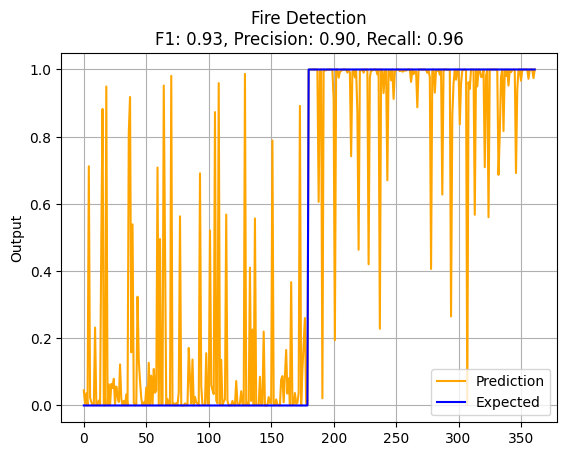

In [21]:
f1 = f1_score(y_test, (y_pred > 0.5).astype(int))
precision = precision_score(y_test, (y_pred > 0.5).astype(int))
recall = recall_score(y_test, (y_pred > 0.5).astype(int))

y_pred = cnn_model.predict(X_test).flatten()  # Get predicted probabilities
chart_regression(y_pred, y_test)

# Keras Auto Tuner: CNN Model
Nicolas Gugliemo Link: https://www.youtube.com/watch?v=6Nf1x7qThR8&list=LL&index=2&t=634s&ab_channel=GregHogg

In [ ]:
from keras_tuner import HyperModel
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

def build_model(hp):
    cnn_input = Input(shape=(128, 128, 3))
    
    # Convolutional Layer 1
    cnn_conv1 = Conv2D(
        filters=hp.Int('conv1_filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('conv1_kernel_size', values=[3, 4, 5]),
        activation='relu'
    )(cnn_input)
    cnn_pool1 = MaxPooling2D(pool_size=(2, 2))(cnn_conv1)
    
    # Convolutional Layer 2
    cnn_conv2 = Conv2D(
        filters=hp.Int('conv2_filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('conv2_kernel_size', values=[3, 4, 5]),
        activation='relu'
    )(cnn_pool1)
    cnn_pool2 = MaxPooling2D(pool_size=(2, 2))(cnn_conv2)
    
    # Flatten Layer
    cnn_flat = Flatten()(cnn_pool2)
    
    # Dense Layer
    cnn_dense = Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
        activation='relu'
    )(cnn_flat)
    
    # Output Layer
    cnn_output = Dense(1, activation='sigmoid')(cnn_dense)
    
    # Compile Model
    model = Model(inputs=cnn_input, outputs=cnn_output)
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [ ]:
from keras_tuner import RandomSearch

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of models to test
    executions_per_trial=1,  # Average over multiple runs
    directory='modelBest',  # Save search results here
    project_name='fire_detection'
)


In [ ]:
tuner.search(X_train, y_train, 
             validation_split=0.2, 
             epochs=10, 
             batch_size=32, 
             verbose=1)

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Best hyperparameters:
- conv1_filters: {best_hps.get('conv1_filters')}
- conv1_kernel_size: {best_hps.get('conv1_kernel_size')}
- conv2_filters: {best_hps.get('conv2_filters')}
- conv2_kernel_size: {best_hps.get('conv2_kernel_size')}
- dense_units: {best_hps.get('dense_units')}
- optimizer: {best_hps.get('optimizer')}
""")

In [ ]:
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, 
                         validation_split=0.2, 
                         epochs=20, 
                         batch_size=32, 
                         verbose=1)

In [ ]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")


In [ ]:
y_pred = best_model.predict(X_test).flatten()  # Get predicted probabilities
chart_regression(y_pred, y_test)

# Testing other CNN Models
Katrina Yu

In [22]:
from tensorflow.keras.utils import to_categorical
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# CNN Model
cnn_input = Input(shape=(128, 128, 3))
cnn_conv1 = Conv2D(128, kernel_size=4, activation='relu')(cnn_input)
cnn_pool1 = MaxPooling2D(pool_size=(2, 2))(cnn_conv1)
cnn_conv2 = Conv2D(64, kernel_size=4, activation='relu')(cnn_pool1)
cnn_pool2 = MaxPooling2D(pool_size=(2, 2))(cnn_conv2)
cnn_flat = Flatten()(cnn_pool2)
cnn_output = Dense(2, activation='softmax')(cnn_flat)

cnn_model = Model(inputs=cnn_input, outputs=cnn_output)
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with EarlyStopping callback
history = cnn_model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, verbose=1, callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Predict and evaluate
y_pred = cnn_model.predict(X_test)
y_pred_binary = y_pred.argmax(axis=1)  # Convert to class indices

# Convert y_test back to class labels
y_test_labels = y_test.argmax(axis=1)

print("Confusion Matrix:\n", confusion_matrix(y_test_labels, y_pred_binary))
print("Classification Report:\n", classification_report(y_test_labels, y_pred_binary, target_names=["No Fire", "Fire"]))

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 125, 125, 128)       │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 62, 62, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 59, 59, 64)          │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 29, 29, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 53824)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │         107,650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 245,058 (957.26 KB)

 Trainable params: 245,058 (957.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.7403 - loss: 0.5415 - val_accuracy: 0.9759 - val_loss: 0.1044
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9371 - loss: 0.1650 - val_accuracy: 0.9172 - val_loss: 0.1928
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9515 - loss: 0.1492 - val_accuracy: 0.9690 - val_loss: 0.1063
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9554 - loss: 0.1509 - val_accuracy: 0.9655 - val_loss: 0.1063
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.8856 - loss: 0.3127 - val_accuracy: 0.9586 - val_loss: 0.1232
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9403 - loss: 0.1584 - val_accuracy: 0.9517 - val_loss: 0.1378
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9465 - loss: 0.1281 - val_accuracy: 0.9586 - val_loss: 0.1149
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9690 - loss: 0.1067 - val_accuracy: 0

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
F1 Score: 0.9388888888888889
Precision: 0.949438202247191
Recall: 0.9285714285714286


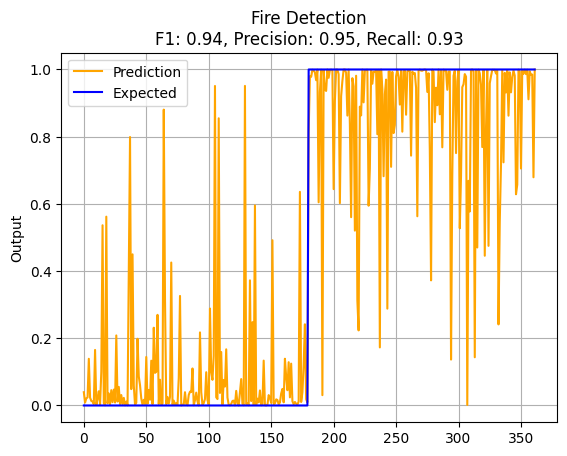

In [23]:
y_pred = cnn_model.predict(X_test)
y_pred_binary = y_pred.argmax(axis=1)  # Convert to class indices
y_test_labels = y_test.argmax(axis=1)  # Convert to class indices

f1 = f1_score(y_test_labels, y_pred_binary)
precision = precision_score(y_test_labels, y_pred_binary)
recall = recall_score(y_test_labels, y_pred_binary)

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

chart_regression(y_pred[:, 1], y_test[:, 1])  # Probabilities for the positive class

# VGG16 Transfer Learning Model
Katrina Yu

In [ ]:
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# Train img with VGG16
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))   #  first hidden layer

# Freezing the layers
for layer in vgg.layers:
    layer.trainable = False

vgg16 = vgg.output
cnn_conv1 = Conv2D(2, kernel_size=3, activation='relu', padding='same')(vgg16)
cnn_pool1 = MaxPooling2D(pool_size=(2, 2))(cnn_conv1)
dropout = Dropout(.5)(cnn_pool1)
cnn_flat = Flatten()(dropout)
output = Dense(2, activation='softmax')(cnn_flat)

vgg16_model = Model(inputs=vgg.input, outputs=output)
vgg16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_model.summary()

monitor = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

vgg16_model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, verbose=1, callbacks=[monitor])


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = vgg16_model.predict(X_test)
y_pred_binary = y_pred.argmax(axis=1)  # Convert to class indices
y_test_labels = y_test.argmax(axis=1)  # Convert to class indices

f1 = f1_score(y_test_labels, y_pred_binary)
precision = precision_score(y_test_labels, y_pred_binary)
recall = recall_score(y_test_labels, y_pred_binary)

# Compute confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_binary)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
class_names = ['Fire', 'No Fire']  # Replace with actual class names
plt.figure()
plot_confusion_matrix(cm, class_names, title='Confusion Matrix')
plt.show()
print(classification_report(y_test_labels, y_pred_binary))

y_true = np.argmax(y_test, axis=1)
pred = vgg16_model.predict(X_test)
pred = pred[:, 1]
plot_roc(y_pred_binary, y_test_labels)

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Keras Auto Tuner: VGG16 Transfer Model 
Nicolas Gugliemo TO-DO (Not sure if a already trained model can be hyper tunned)